# Burgers Equation Identification Using PINN-Adam Optimizer
Equation:   $u_{t} + \lambda_1 uu_{x}-\lambda_2 u_{xx} = 0$  

In [6]:
#author : $um@nth
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import grad
import scipy.io
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [7]:
N_u = 2500
layers = [2, 25, 25, 25, 25, 25, 25, 25, 25, 1]
data = scipy.io.loadmat('burgers_shock.mat') 
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))                  
u_star = Exact.flatten()[:,None]                                                 
lb = X_star.min(0)                                                              
ub = X_star.max(0)
np.random.seed(107)
idx = np.random.choice(X_star.shape[0], N_u, replace=False)

X_train = X_star[idx,:]
u_train = torch.from_numpy(u_star[idx,:]).float()
X = torch.from_numpy(X_train[:,0:1]).requires_grad_(True).float()     
T = torch.from_numpy(X_train[:,1:2]).requires_grad_(True).float()

In [8]:
class Data(Dataset):

  def __init__(self, X, T, u_train):
    self.x = torch.cat([X, T], axis=1).float()
    self.y = u_train
    self.len = u_train.shape[0]
  
  def __getitem__(self, index):    
      return self.x[index], self.y[index]
  
  def __len__(self):
      return self.len

In [9]:
data_set = Data(X, T, u_train)
train_loader = DataLoader(dataset=data_set, batch_size=128)

# PINN

In [10]:
class PINN(nn.Module):

  def __init__(self, layers):
    super(PINN, self).__init__()
    self.layers = nn.ModuleList()
    for i, j in zip(layers, layers[1:]):
      linear = nn.Linear(i, j)
      nn.init.xavier_normal_(linear.weight.data, gain = 1.0)
      nn.init.zeros_(linear.bias.data)
      self.layers.append(linear)
  
  def forward(self, x):
    L = len(self.layers)
    for l, transform in enumerate(self.layers):
      if l < L-1:
        x = torch.tanh(transform(x))
      else:
        x = transform(x)
    return x   

In [11]:
pinn_model = PINN(layers)
l1 = nn.Parameter(torch.tensor([0.], requires_grad=True))
l2 = nn.Parameter(torch.tensor([0.], requires_grad=True))
pinn_model.register_parameter('lambda_1', l1)
pinn_model.register_parameter('lambda_2', l2)
optimizer = torch.optim.Adam(pinn_model.parameters(), lr = 0.0005)

In [12]:
def residual_loss(X, T, model, l1, l2):
  xf = torch.cat([X, T], axis=1)
  uf = model(xf)
  u_x = grad(uf.sum(), X, retain_graph = True, create_graph = True)[0]
  u_xx = grad(u_x.sum(), X, retain_graph = True, create_graph = True)[0]
  u_t = grad(uf.sum(), T, retain_graph = True, create_graph = True)[0]
  f = u_t + l1*uf*u_x - l2*u_xx 
  return torch.mean(torch.square(f))

In [13]:
def PINN_train(model, train_loader, optimizer, X, T, l1, l2):
  epochs = 5500
  nu = 0.01/np.pi
  mse = nn.MSELoss()
  l1_error = []
  l2_error = []
  for epoch in range(epochs):
    for x1, y1 in train_loader:
      model.train()
      optimizer.zero_grad()
      yhat = model(x1)
      loss1 = mse(yhat, y1)
      loss2 = residual_loss(X, T, model, l1, l2)
      loss = loss1 + loss2
      loss.backward()
      optimizer.step()
    error_lambda_1 = np.abs(l1.detach().numpy() - 1.0)*100
    error_lambda_2 = np.abs(l2.detach().numpy() - nu)/nu * 100
    l1_error.append(error_lambda_1)
    l2_error.append(error_lambda_2)
    if epoch % 100 == 0:
      print('Epoch:', epoch, 'Loss: %.5e, Lambda_1: %.5f, Lambda_2: %.5f' % (loss.item(), l1, l2))
  return np.array(l1_error), np.array(l2_error)

In [14]:
arr1, arr2 = PINN_train(pinn_model, train_loader, optimizer, X, T, l1, l2)

Epoch: 0 Loss: 2.58724e-01, Lambda_1: -0.00803, Lambda_2: 0.00023
Epoch: 100 Loss: 2.25971e-02, Lambda_1: 0.35946, Lambda_2: 0.00309
Epoch: 200 Loss: 7.19443e-03, Lambda_1: 0.65177, Lambda_2: 0.00522
Epoch: 300 Loss: 3.88787e-03, Lambda_1: 0.77401, Lambda_2: 0.00526
Epoch: 400 Loss: 2.00743e-03, Lambda_1: 0.84290, Lambda_2: 0.00512
Epoch: 500 Loss: 8.60239e-04, Lambda_1: 0.89261, Lambda_2: 0.00476
Epoch: 600 Loss: 7.05578e-04, Lambda_1: 0.91328, Lambda_2: 0.00498
Epoch: 700 Loss: 5.46234e-04, Lambda_1: 0.92732, Lambda_2: 0.00500
Epoch: 800 Loss: 3.18207e-04, Lambda_1: 0.94439, Lambda_2: 0.00447
Epoch: 900 Loss: 2.55431e-04, Lambda_1: 0.95262, Lambda_2: 0.00430
Epoch: 1000 Loss: 2.33165e-04, Lambda_1: 0.95555, Lambda_2: 0.00461
Epoch: 1100 Loss: 2.31934e-04, Lambda_1: 0.95834, Lambda_2: 0.00460
Epoch: 1200 Loss: 4.89964e-04, Lambda_1: 0.96922, Lambda_2: 0.00420
Epoch: 1300 Loss: 1.51554e-04, Lambda_1: 0.97292, Lambda_2: 0.00416
Epoch: 1400 Loss: 1.45566e-04, Lambda_1: 0.97293, Lambda_2:

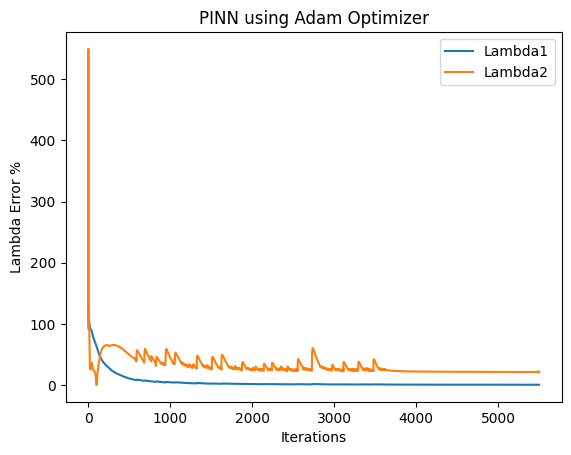

In [16]:
plt.plot(np.arange(1, 5501), arr1, label='Lambda1')
plt.plot(np.arange(1, 5501), arr2, label='Lambda2')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Lambda Error %')
plt.title('PINN using Adam Optimizer')
plt.show()

In [17]:
lambda1 = float(pinn_model.lambda_1.data)
lambda2 = float(pinn_model.lambda_2.data)
print('Lambda1 Pred:', round(lambda1,8), '  ; Lambda1 Actual:', 1.0)
print('Lambda2 Pred:', round(lambda2,8), '  ; Lambda2 Actual:', round(0.01/np.pi,8))

Lambda1 Pred: 0.99531293   ; Lambda1 Actual: 1.0
Lambda2 Pred: 0.003856   ; Lambda2 Actual: 0.0031831
